In [36]:
import pandas as pd

from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np

import torch

from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

In [37]:
import wandb

# Disable wandb logging for this script
wandb.init(mode="disabled")

In [ ]:
# Load the training and validation data for subtask 1

train = pd.read_csv('C:/Users/kamal/Documents/NLP/Project/dev_phase/subtask1/train/arb.csv')
val = pd.read_csv('C:/Users/kamal/Documents/NLP/Project/dev_phase/subtask1/dev/arb .csv')

train.head()

,id,text,polarization
0,ar_a2a60c8b4af3389e842d8ec31afb0eea,احلام انتي ونعالي ومنو انتي حتى تقيمين الفناني...,1
1,ar_6723e56a672674a6c1d9b28b213c4a05,وره الكواليس تنيجج من وره بعير صطناعي على فكرة...,1
2,ar_b0365d606edeee38ae6c025b1ca33e96,.خخخخ الملكه احلام فيها شذوذ شنو هل بوس والدلع...,1
3,ar_858c0ee684049ba6f416a6cecb0b0761,الله يخزي احلام هي والبرنامج الخايس الي كله مصخره,1
4,ar_bdafc73afd0bc2cd2badae2a089446b9,كس ام احلام الي ماربتها وش ملكه هههه متستاهل م...,1


In [39]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
  def __init__(self,texts,labels,tokenizer,max_length =128):
    self.texts=texts
    self.labels=labels
    self.tokenizer= tokenizer
    self.max_length = max_length # Store max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self,idx):
    text=self.texts[idx]
    label=self.labels[idx]
    encoding=self.tokenizer(text,truncation=True,padding=False,max_length=self.max_length,return_tensors='pt')

    # Ensure consistent tensor conversion for all items
    item = {key: encoding[key].squeeze() for key in encoding.keys()}
    item['labels'] = torch.tensor(label, dtype=torch.long)
    return item

In [40]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

# Create datasets
from sklearn.model_selection import train_test_split

# Assuming 'train' dataset has columns 'text' and 'polarization'
train_texts = train['text'].tolist()
train_labels = train['polarization'].tolist()

# Split the training data into 80% train and 20% validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

# Create datasets for both train and validation
train_dataset = PolarizationDataset(train_texts, train_labels, tokenizer)
val_dataset = PolarizationDataset(val_texts, val_labels, tokenizer)


In [41]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# Define metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

# Define training arguments
training_args = TrainingArguments(
        output_dir=f"./",
        num_train_epochs=3,
        learning_rate=2e-5,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=8,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=100,
        disable_tqdm=False
    )


In [43]:
# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
    data_collator=DataCollatorWithPadding(tokenizer) # Data collator for dynamic padding
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set: {eval_results['eval_f1_macro']}")

Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.532640,0.730429
2,No log,0.504374,0.740711
3,0.514800,0.517547,0.743675


Macro F1 score on validation set: 0.74367521141416


In [44]:
print(eval_results)

{'eval_loss': 0.5175468921661377, 'eval_f1_macro': 0.74367521141416, 'eval_runtime': 19.0735, 'eval_samples_per_second': 35.442, 'eval_steps_per_second': 4.456, 'epoch': 3.0}


=== Subtask 1: Polarization Detection Report ===
Accuracy: 0.7456

               precision    recall  f1-score   support

Not Polarized       0.76      0.77      0.77       366
    Polarized       0.72      0.72      0.72       310

     accuracy                           0.75       676
    macro avg       0.74      0.74      0.74       676
 weighted avg       0.75      0.75      0.75       676



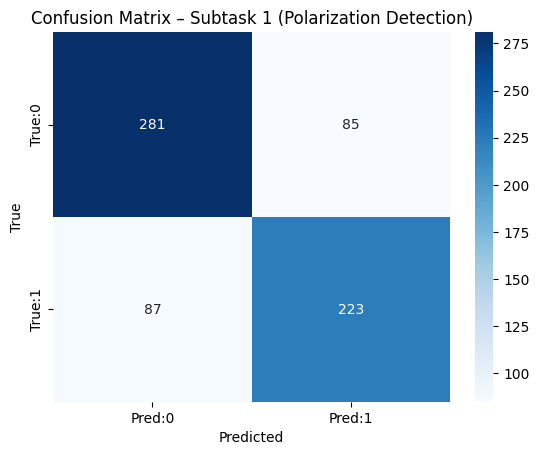

In [45]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# get predictions
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print("=== Subtask 1: Polarization Detection Report ===")
print(f"Accuracy: {accuracy_score(labels, preds):.4f}\n")
print(classification_report(labels, preds, target_names=["Not Polarized", "Polarized"], zero_division=0))

# confusion matrix
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred:0", "Pred:1"], yticklabels=["True:0", "True:1"])
plt.title("Confusion Matrix – Subtask 1 (Polarization Detection)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [46]:
print(predictions)

PredictionOutput(predictions=array([[ 2.0251946 , -1.5282866 ],
       [-0.3697414 ,  0.49855253],
       [-1.2856144 ,  1.1928072 ],
       ...,
       [ 0.8522681 , -0.6223494 ],
       [-1.0312495 ,  0.9704792 ],
       [ 1.2390354 , -0.7871649 ]], dtype=float32), label_ids=array([0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1